In [1]:
import pandas as pd

df = pd.read_csv(r'E:\Programming\python\Machine-Learning\data\housing.data', header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [2]:
##탐색적 행렬 분석##

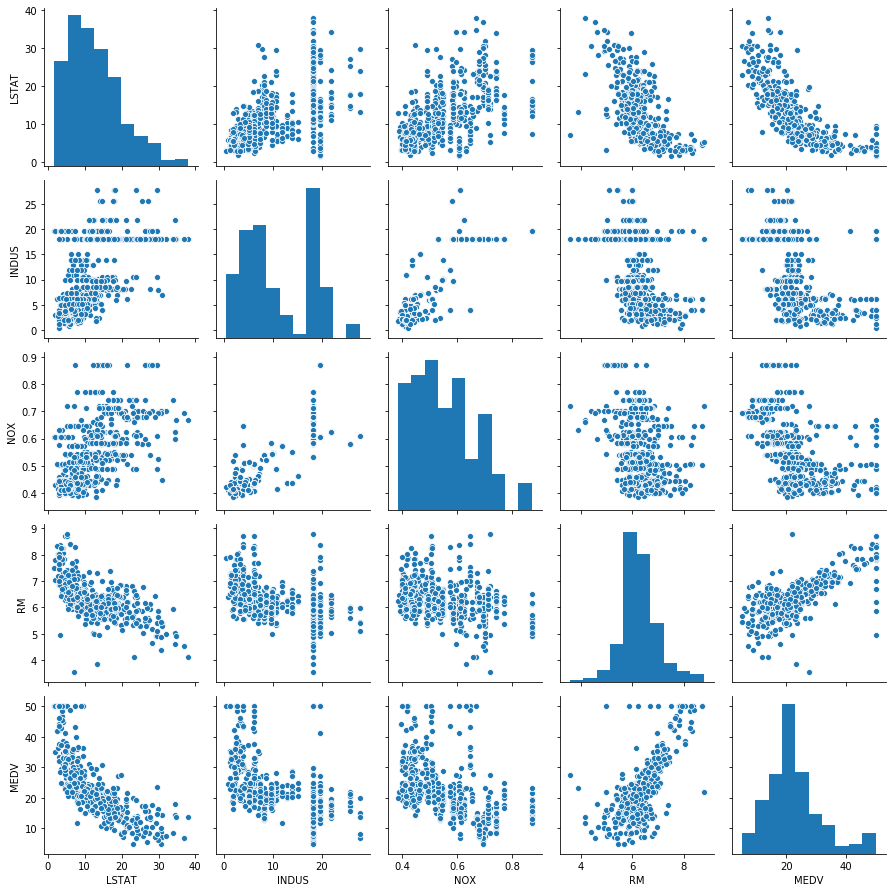

In [3]:
##산점도 행렬 보기
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

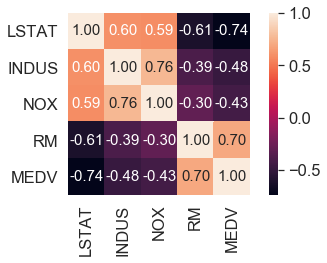

In [4]:
##히트맵 그리기
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.tight_layout()
plt.show()

In [5]:
##아달린의 경사 하강법 코드에서 단위 계단 함수를 제거한 첫 번째 선형 회귀 모델

class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [6]:
##경사 하강법이 잘 수렴하도록 특성 표준화 전처리하기
from sklearn.preprocessing import StandardScaler  ##사이킷런은 대부분의 변환기는 2차원의 배열로 저장되기 기대함

X = df[['RM']].values
y = df['MEDV'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()  ##np.newaxis가 차원을 추가해줌. 그 후 flatten()으로 다시 1차원의 형태로 돌려줌
lr = LinearRegressionGD()
lr.fit(X_std, y_std)


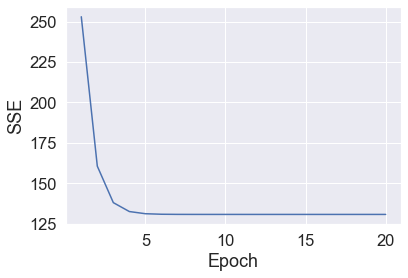

In [7]:
##에포크 함수로 비용을 그래프로 그려보기

plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

#5에서 수렴

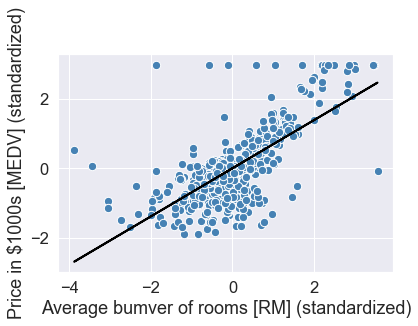

In [8]:
##선형 회귀 모델이 훈련 데이터에 얼마나 잘 맞는지 그려 보기 위한 함수

def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolors='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

##RM(방 개수)와 MEDV(주택 가격)에 관한 그래프 그리기

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average bumver of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [9]:
##예측된 출력 값을 원본 스케일로 복원하기

num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("$1,000 단위의 가격: %.3f" %\
      sc_y.inverse_transform(price_std))  ##5개의 방을 가진 주택 가격은 1만 840달러

$1,000 단위의 가격: 10.840


In [10]:
#y 절편이 항상 0이기 떄문에 절편을 업데이트 할 필요가 없다
print('기울기: %.3f' % lr.w_[1])
print('절편: %.3f' % lr.w_[0])

기울기: 0.695
절편: -0.000


In [11]:
##사이킷런의 회귀모델 사용하기
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

##표준화 되지 않은 값을 변수에 훈련시키면 모델의 가중치가 달라진다

기울기: 9.102
절편: -34.671


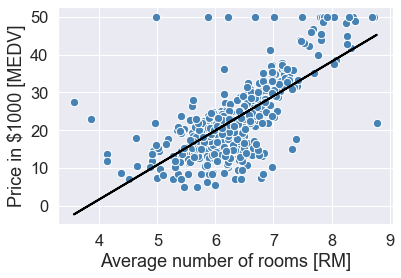

In [12]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000 [MEDV]')
plt.show()

In [13]:
##RANSAC를 사용하기
from sklearn.linear_model import RANSACRegressor

ransac =RANSACRegressor(LinearRegression(),
                        max_trials=100,     ##최대 반복횟수 100
                        min_samples=50,     ##랜덤하게 선택할 샘플의 최소 개수 50개
                        loss='absolute_loss', ##알고리즘이 학습한 직선과 샘플 포인트간의 수직 거리의 절대값
                        residual_threshold=5.0,  ##수직 거리가 5 이내에 있는 정상 샘플만 포함
                        random_state=0)

ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=50, random_state=0,
                residual_threshold=5.0, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

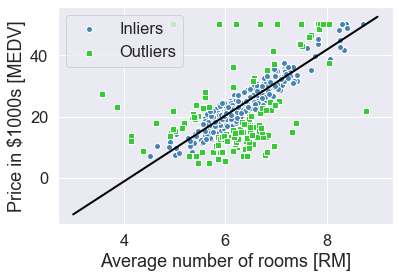

기울기: 10.735
절편: -44.089


In [14]:
##학습된 모델에서 정상치와 이상치 얻기
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolors='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolors='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

In [15]:
##모든 변수를 사용하여 다변량 회귀모델 훈련하기
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

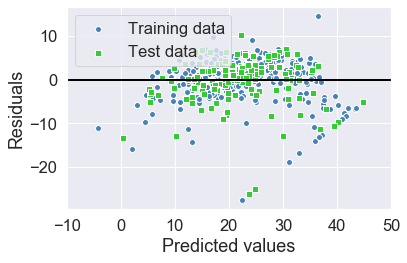

In [16]:
##잔차 그래프 그리기
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolors='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolors='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, colors='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [17]:
##MSE 계산하기
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)
))

훈련 MSE: 19.958, 테스트 MSE: 27.196


In [18]:
##결정계수 계산하기
from sklearn.metrics import r2_score

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %
      (r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

훈련 R^2: 0.765, 테스트 R^2: 0.673


In [19]:
####회귀에 규제 적용####

In [20]:
##릿지 회귀 모델
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

In [21]:
##라쏘 회귀 모델
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)

In [22]:
##엘라스틱 넷
from sklearn.linear_model import ElasticNet

elanet = ElasticNet(alpha=1.0, l1_ratio=0.5) ##l1_ratio를 1.0으로 설정하면 라쏘 회귀와 동일해짐

In [23]:
##다항식 항 추가하기
from sklearn.preprocessing import PolynomialFeatures
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0,
              368.0, 396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]
y = np.array([ 236.0, 234.4, 252.8, 298.6, 314.2,
              342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [24]:
##비교를 위해 훈련하기
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [25]:
##변화된 특성에서 다변량 회귀 모델 훈련하기
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

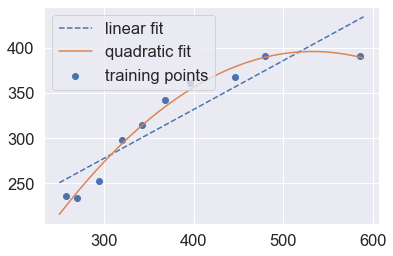

훈련 MSE 비교 - 선형 모델: 571.294, 다항 모델: 60.501
훈련 R^2 비교 - 선형 모델: 0.832, 다항 모델: 0.982


In [26]:
##결과 그래프 그리기
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('훈련 MSE 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
    mean_squared_error(y, y_lin_pred),
    mean_squared_error(y, y_quad_pred)
))
print('훈련 R^2 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
    r2_score(y, y_lin_pred),
    r2_score(y, y_quad_pred)
))

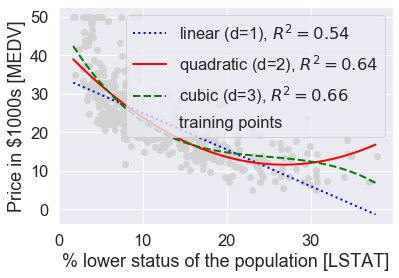

In [27]:
##주택 데이터셋에 적용하기

X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

#이차, 삼차 다항식 특성을 만들기
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#학습된 모델을 그리기 위해 특성 범위를 만듭니다
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

#결과 그래프 그리기
plt.scatter(X, y, label='training points', color='lightgrey')

plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green',
         lw=2,
         linestyle='--')    

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

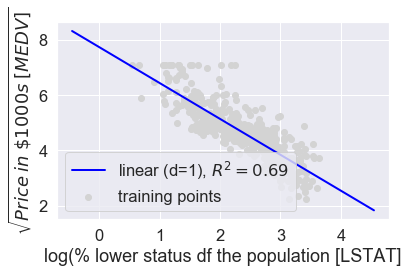

In [28]:
#특성 변환하기
X_log = np.log(X)
y_sqrt = np.sqrt(y)

#학습된 모델을 그리기 위해 특성 범위 생성
X_fit = np.arange(X_log.min()-1,
                  X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

#결과 그래프 만들기
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2)

plt.xlabel('log(% lower status df the population [LSTAT]')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

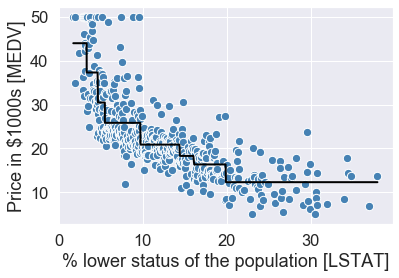

In [29]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [30]:
##랜덤 포레스트 회귀
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.4,
                     random_state=1)

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)
))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)
))

훈련 MSE: 1.641, 테스트 MSE: 11.056
훈련 R^2: 0.979, 테스트 R^2: 0.878


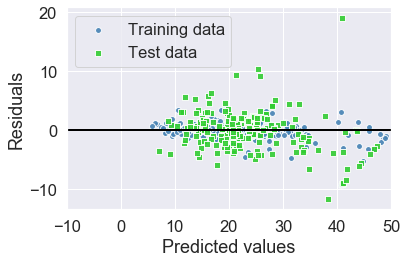

In [31]:
##예측 잔차 확인하기

plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Training data')

plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            edgecolors='white',
            marker='s',
            s=35,
            alpha=0.9,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upeer left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, colors='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()